In [ ]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from tqdm import tnrange, tqdm_notebook
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd

# Your existing code to read and merge data
file_paths = ['https://www.iso-ne.com/static-assets/documents/2020/02/2020_smd_hourly.xlsx',
              'https://www.iso-ne.com/static-assets/documents/2021/02/2021_smd_hourly.xlsx',
              'https://www.iso-ne.com/static-assets/documents/2022/02/2022_smd_hourly.xlsx']

yearly_data = []

for file_path in file_paths:
    xls = pd.ExcelFile(file_path)
    if "NH" in xls.sheet_names:
        nh_data = pd.read_excel(file_path, sheet_name="NH")
        yearly_data.append(nh_data)

merged_data = pd.concat(yearly_data, ignore_index=True)

# Remove unwanted columns
columns_to_remove = ["DA_Demand", "DA_LMP", "DA_EC", "DA_CC", "DA_MLC", "RT_LMP", "RT_EC", "RT_CC", "RT_MLC"]
merged_data = merged_data.drop(columns=columns_to_remove)
merged_data

Date  Hr_End  RT_Demand  Dry_Bulb  Dew_Point
0     2020-01-01       1   1080.184        32         30
1     2020-01-01       2   1034.726        34         27
2     2020-01-01       3   1005.343        34         26
3     2020-01-01       4   1000.609        33         24
4     2020-01-01       5   1011.067        31         24
...          ...     ...        ...       ...        ...
26299 2022-12-31      20   1282.789        51         49
26300 2022-12-31      21   1219.789        50         48
26301 2022-12-31      22   1158.510        46         45
26302 2022-12-31      23   1092.783        45         44
26303 2022-12-31      24   1032.948        45         44

[26304 rows x 5 columns]

In [ ]:
# Adding Additional Columns
# Extracting relevant features
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data['Day_of_Week'] = merged_data['Date'].dt.dayofweek
merged_data['Day_of_Month'] = merged_data['Date'].dt.day
merged_data['Month'] = merged_data['Date'].dt.month

# Additional transformations
merged_data['Dry_Bulb_Squared'] = merged_data['Dry_Bulb'] ** 2
merged_data['Dew_Point_Squared'] = merged_data['Dew_Point'] ** 2
merged_data['Dry_Bulb_Dew_Point_Interact'] = merged_data['Dry_Bulb'] * merged_data['Dew_Point']

In [ ]:
merged_data

Date  Hr_End  RT_Demand  Dry_Bulb  Dew_Point  Day_of_Week  \
0     2020-01-01       1   1080.184        32         30            2   
1     2020-01-01       2   1034.726        34         27            2   
2     2020-01-01       3   1005.343        34         26            2   
3     2020-01-01       4   1000.609        33         24            2   
4     2020-01-01       5   1011.067        31         24            2   
...          ...     ...        ...       ...        ...          ...   
26299 2022-12-31      20   1282.789        51         49            5   
26300 2022-12-31      21   1219.789        50         48            5   
26301 2022-12-31      22   1158.510        46         45            5   
26302 2022-12-31      23   1092.783        45         44            5   
26303 2022-12-31      24   1032.948        45         44            5   

       Day_of_Month  Month  Dry_Bulb_Squared  Dew_Point_Squared  \
0                 1      1              1024                900   
1                 1      1              1156                729   
2                 1      1              1156                676   
3                 1      1              1089                576   
4                 1      1               961                576   
...             ...    ...               ...                ...   
26299            31     12              2601               2401   
26300            31     12              2500               2304   
26301            31     12              2116               2025   
26302            31     12              2025               1936   
26303            31     12              2025               1936   

       Dry_Bulb_Dew_Point_Interact  
0                              960  
1                              918  
2                              884  
3                              792  
4                              744  
...                            ...  
26299                         2499  
26300                         2400  
26301                         2070  
26302                         1980  
26303                         1980  

[26304 rows x 11 columns]

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         26304 non-null  datetime64[ns]
 1   Hr_End                       26304 non-null  int64         
 2   RT_Demand                    26304 non-null  float64       
 3   Dry_Bulb                     26304 non-null  int64         
 4   Dew_Point                    26304 non-null  int64         
 5   Day_of_Week                  26304 non-null  int64         
 6   Day_of_Month                 26304 non-null  int64         
 7   Month                        26304 non-null  int64         
 8   Dry_Bulb_Squared             26304 non-null  int64         
 9   Dew_Point_Squared            26304 non-null  int64         
 10  Dry_Bulb_Dew_Point_Interact  26304 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(9

In [ ]:
merged_data.describe()

Hr_End     RT_Demand      Dry_Bulb     Dew_Point   Day_of_Week  \
count  26304.000000  26304.000000  26304.000000  26304.000000  26304.000000   
mean      12.500000   1295.402554     49.142868     37.412979      3.001825   
std        6.922318    262.760623     19.677216     19.708705      1.997755   
min        1.000000    769.478000     -9.000000    -19.000000      0.000000   
25%        6.750000   1110.889000     34.000000     23.000000      1.000000   
50%       12.500000   1276.953500     49.000000     37.000000      3.000000   
75%       18.250000   1449.707500     65.000000     55.000000      5.000000   
max       24.000000   2462.235000     97.000000     75.000000      6.000000   

       Day_of_Month         Month  Dry_Bulb_Squared  Dew_Point_Squared  \
count  26304.000000  26304.000000      26304.000000       26304.000000   
mean      15.732664      6.521898       2802.199589        1788.149293   
std        8.801537      3.449052       1970.167928        1456.237200   
min        1.000000      1.000000          0.000000           0.000000   
25%        8.000000      4.000000       1156.000000         529.000000   
50%       16.000000      7.000000       2401.000000        1369.000000   
75%       23.000000     10.000000       4225.000000        3025.000000   
max       31.000000     12.000000       9409.000000        5625.000000   

       Dry_Bulb_Dew_Point_Interact  
count                 26304.000000  
mean                   2179.185751  
std                    1642.639575  
min                    -273.000000  
25%                     777.000000  
50%                    1764.000000  
75%                    3540.000000  
max                    6816.000000

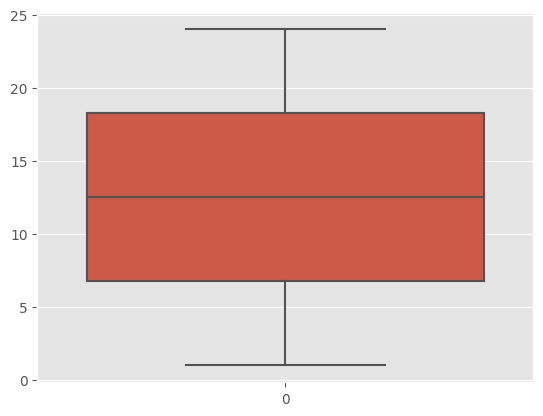

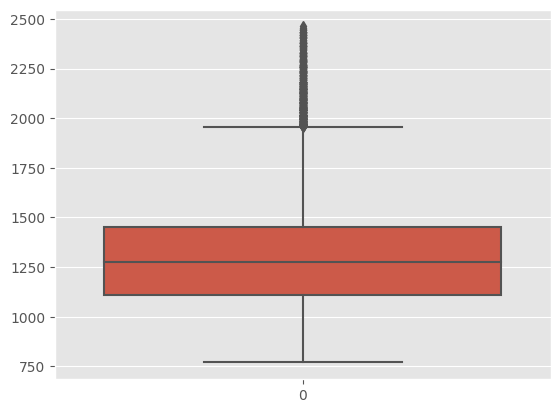

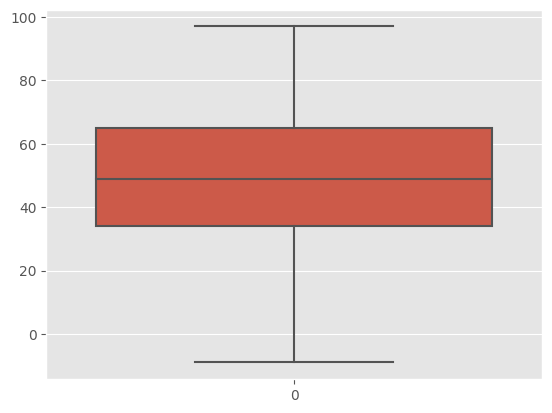

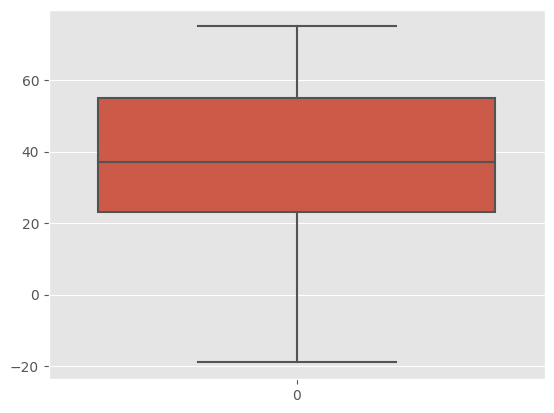

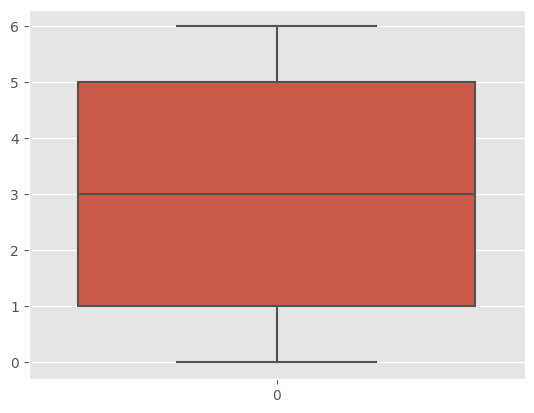

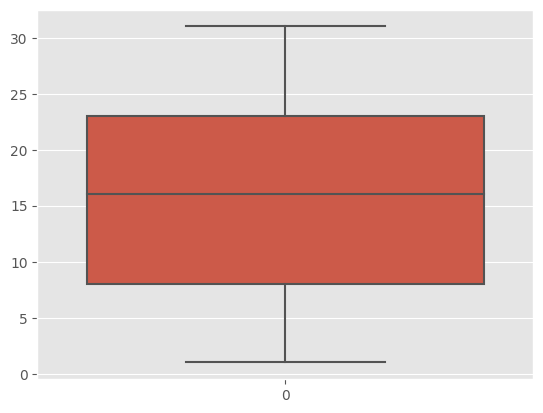

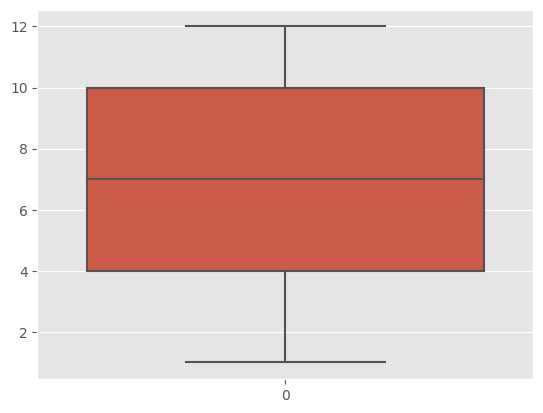

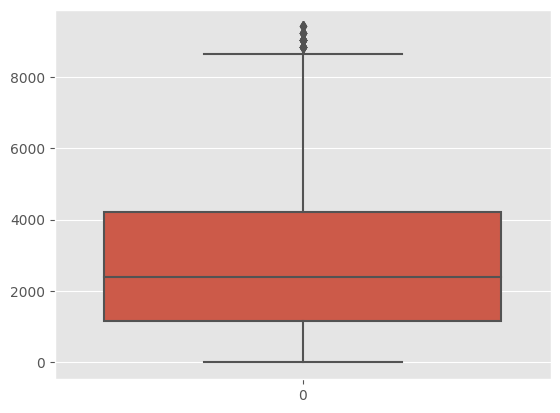

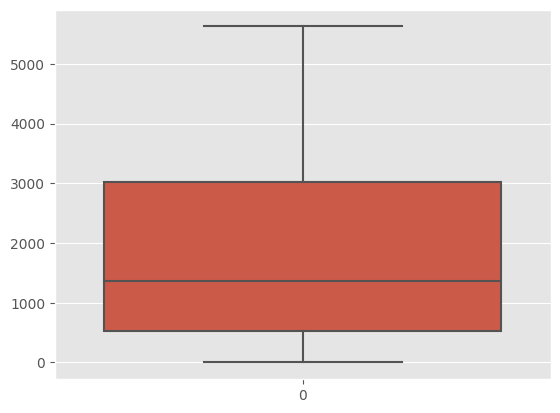

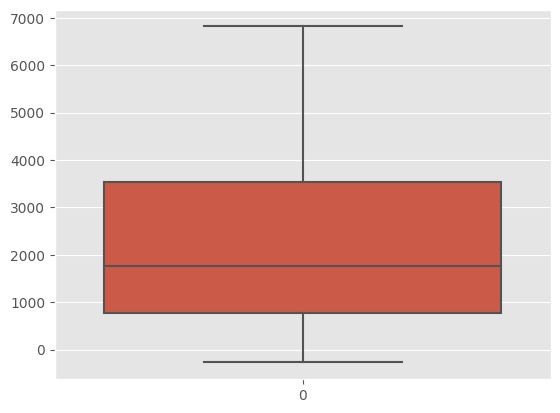

In [ ]:
cols=['Hr_End','RT_Demand','Dry_Bulb','Dew_Point', 'Day_of_Week', 'Day_of_Month', 'Month', 'Dry_Bulb_Squared','Dew_Point_Squared','Dry_Bulb_Dew_Point_Interact'];

for i in cols:
    sns.boxplot(merged_data[i])
    plt.show()

In [ ]:
merged_data.skew()

Hr_End                         0.000000
RT_Demand                      0.744521
Dry_Bulb                      -0.031554
Dew_Point                     -0.197036
Day_of_Week                   -0.001825
Day_of_Month                   0.006505
Month                         -0.008907
Dry_Bulb_Squared               0.663558
Dew_Point_Squared              0.548615
Dry_Bulb_Dew_Point_Interact    0.508519
dtype: float64

In [ ]:
print(merged_data.std())

Date                           316 days 09:27:06.916778836
Hr_End                                            6.922318
RT_Demand                                       262.760623
Dry_Bulb                                         19.677216
Dew_Point                                        19.708705
Day_of_Week                                       1.997755
Day_of_Month                                      8.801537
Month                                             3.449052
Dry_Bulb_Squared                               1970.167928
Dew_Point_Squared                                1456.2372
Dry_Bulb_Dew_Point_Interact                    1642.639575
dtype: object


In [ ]:
print(merged_data.var())

Hr_End                         4.791849e+01
RT_Demand                      6.904314e+04
Dry_Bulb                       3.871928e+02
Dew_Point                      3.884331e+02
Day_of_Week                    3.991024e+00
Day_of_Month                   7.746706e+01
Month                          1.189596e+01
Dry_Bulb_Squared               3.881562e+06
Dew_Point_Squared              2.120627e+06
Dry_Bulb_Dew_Point_Interact    2.698265e+06
dtype: float64


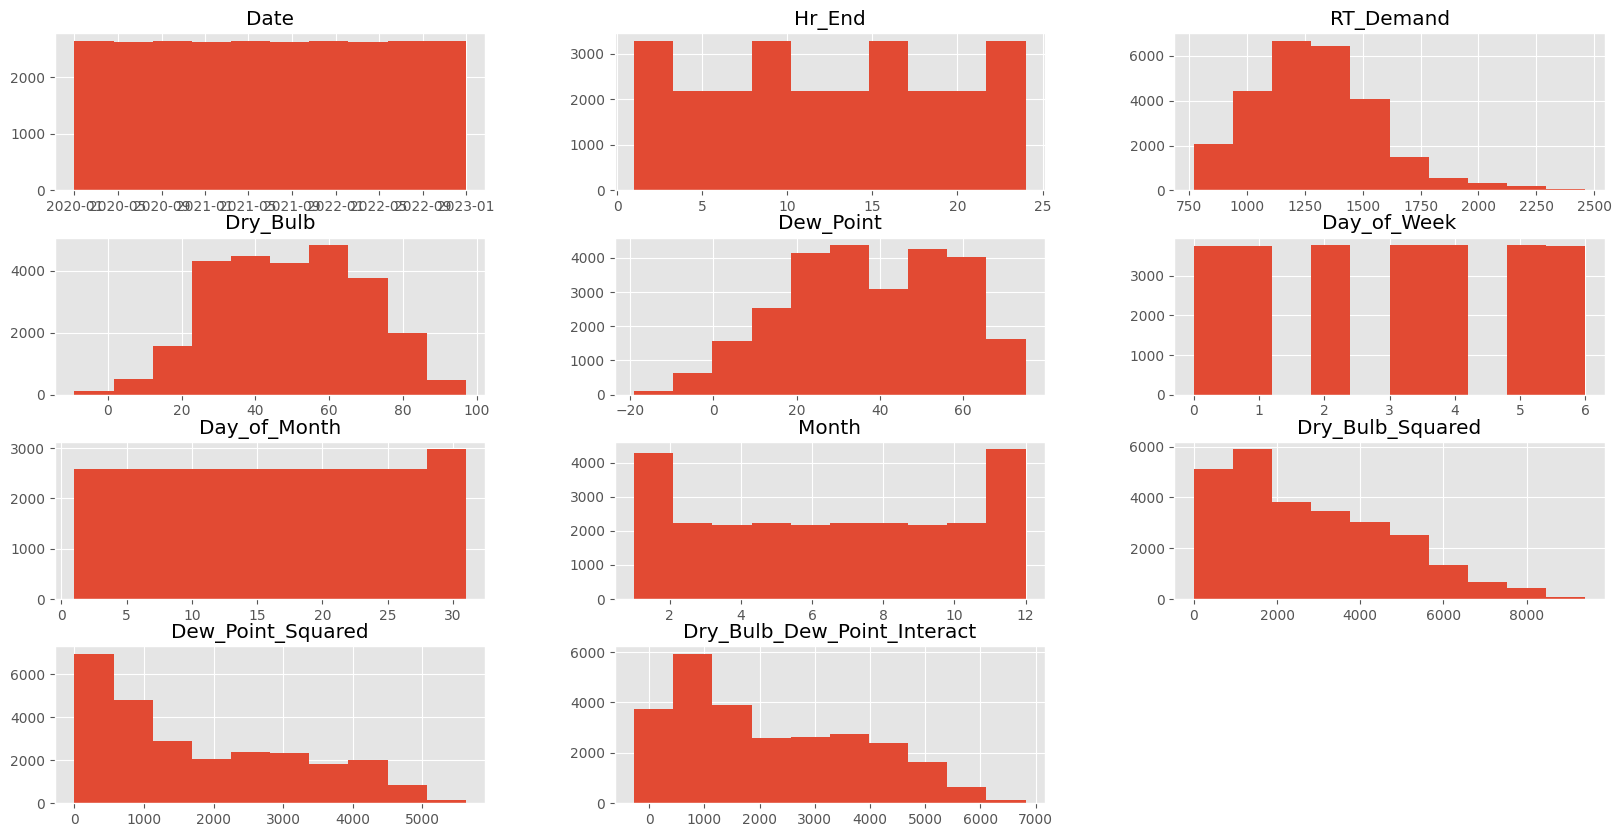

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
merged_data.hist();

<Axes: xlabel='Dew_Point_Squared', ylabel='Density'>

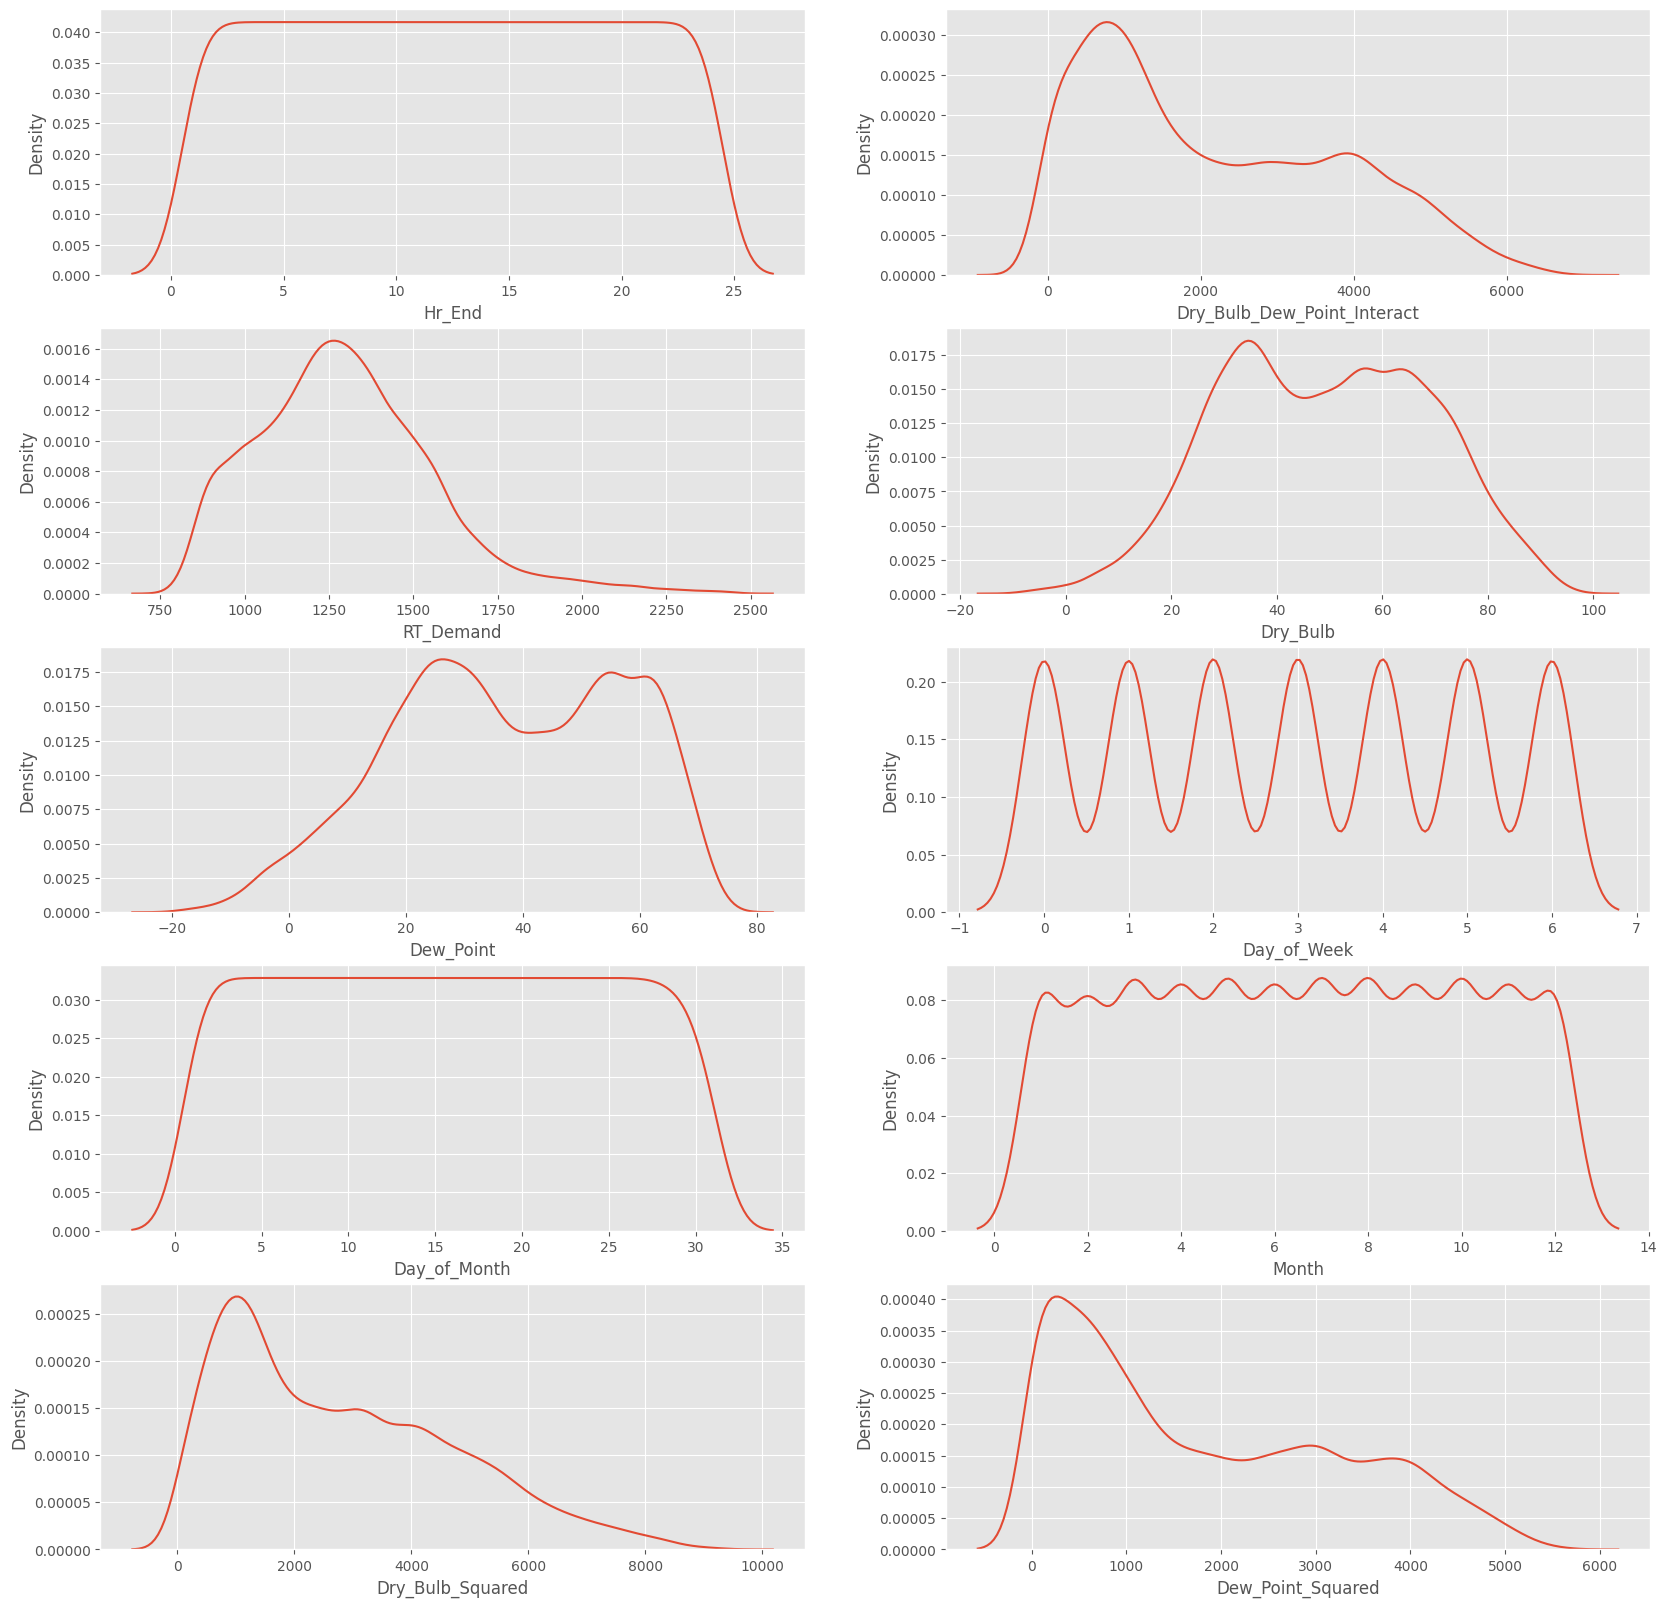

In [ ]:
fig,axs=plt.subplots(5,2,figsize=(20,20))
sns.distplot(merged_data['Hr_End'],ax=axs[0,0],hist=False)
sns.distplot(merged_data['Dry_Bulb_Dew_Point_Interact'],ax=axs[0,1],hist=False)
sns.distplot(merged_data['RT_Demand'],ax=axs[1,0],hist=False)
sns.distplot(merged_data['Dry_Bulb'],ax=axs[1,1],hist=False)
sns.distplot(merged_data['Dew_Point'],ax=axs[2,0],hist=False)
sns.distplot(merged_data['Day_of_Week'],ax=axs[2,1],hist=False)
sns.distplot(merged_data['Day_of_Month'],ax=axs[3,0],hist=False)
sns.distplot(merged_data['Month'],ax=axs[3,1],hist=False)
sns.distplot(merged_data['Dry_Bulb_Squared'],ax=axs[4,0],hist=False)
sns.distplot(merged_data['Dew_Point_Squared'],ax=axs[4,1],hist=False)

In [ ]:
merged_data.corr()

Hr_End  RT_Demand  Dry_Bulb  Dew_Point  \
Hr_End                       1.000000e+00   0.430536  0.174121   0.014022   
RT_Demand                    4.305363e-01   1.000000  0.252229   0.117405   
Dry_Bulb                     1.741205e-01   0.252229  1.000000   0.878305   
Dew_Point                    1.402181e-02   0.117405  0.878305   1.000000   
Day_of_Week                 -8.819601e-18  -0.154864 -0.010653  -0.017672   
Day_of_Month                -1.139306e-16   0.044830 -0.001720  -0.005039   
Month                       -9.842558e-16  -0.037434  0.251559   0.325826   
Dry_Bulb_Squared             1.812297e-01   0.378502  0.975436   0.835126   
Dew_Point_Squared            1.431618e-02   0.240712  0.848871   0.960141   
Dry_Bulb_Dew_Point_Interact  8.666176e-02   0.314165  0.933546   0.947336   

                              Day_of_Week  Day_of_Month         Month  \
Hr_End                      -8.819601e-18 -1.139306e-16 -9.842558e-16   
RT_Demand                   -1.548635e-01  4.482998e-02 -3.743398e-02   
Dry_Bulb                    -1.065290e-02 -1.719791e-03  2.515587e-01   
Dew_Point                   -1.767213e-02 -5.038668e-03  3.258258e-01   
Day_of_Week                  1.000000e+00  1.315306e-04 -4.773035e-03   
Day_of_Month                 1.315306e-04  1.000000e+00  1.006662e-02   
Month                       -4.773035e-03  1.006662e-02  1.000000e+00   
Dry_Bulb_Squared            -5.492416e-03  1.096371e-02  2.106335e-01   
Dew_Point_Squared           -1.631210e-02  1.588636e-02  2.714488e-01   
Dry_Bulb_Dew_Point_Interact -1.138063e-02  1.322294e-02  2.596782e-01   

                             Dry_Bulb_Squared  Dew_Point_Squared  \
Hr_End                               0.181230           0.014316   
RT_Demand                            0.378502           0.240712   
Dry_Bulb                             0.975436           0.848871   
Dew_Point                            0.835126           0.960141   
Day_of_Week                         -0.005492          -0.016312   
Day_of_Month                         0.010964           0.015886   
Month                                0.210634           0.271449   
Dry_Bulb_Squared                     1.000000           0.849190   
Dew_Point_Squared                    0.849190           1.000000   
Dry_Bulb_Dew_Point_Interact          0.945812           0.972500   

                             Dry_Bulb_Dew_Point_Interact  
Hr_End                                          0.086662  
RT_Demand                                       0.314165  
Dry_Bulb                                        0.933546  
Dew_Point                                       0.947336  
Day_of_Week                                    -0.011381  
Day_of_Month                                    0.013223  
Month                                           0.259678  
Dry_Bulb_Squared                                0.945812  
Dew_Point_Squared                               0.972500  
Dry_Bulb_Dew_Point_Interact                     1.000000

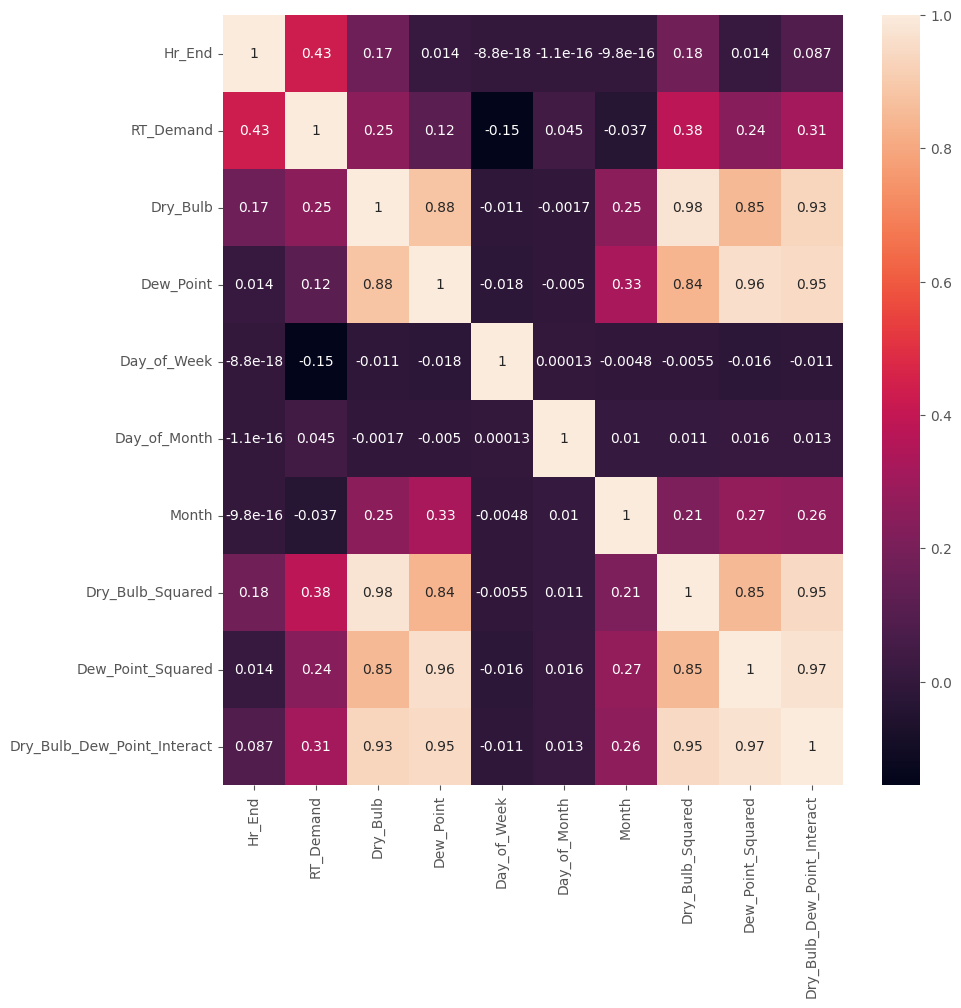

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(merged_data.corr(method='pearson'),annot=True);

In [ ]:
max_corr = merged_data.corr().abs().unstack().sort_values(kind='quicksort', ascending= False)
max_corr[max_corr<1].head(25)

Dry_Bulb                     Dry_Bulb_Squared               0.975436
Dry_Bulb_Squared             Dry_Bulb                       0.975436
Dry_Bulb_Dew_Point_Interact  Dew_Point_Squared              0.972500
Dew_Point_Squared            Dry_Bulb_Dew_Point_Interact    0.972500
                             Dew_Point                      0.960141
Dew_Point                    Dew_Point_Squared              0.960141
                             Dry_Bulb_Dew_Point_Interact    0.947336
Dry_Bulb_Dew_Point_Interact  Dew_Point                      0.947336
Dry_Bulb_Squared             Dry_Bulb_Dew_Point_Interact    0.945812
Dry_Bulb_Dew_Point_Interact  Dry_Bulb_Squared               0.945812
Dry_Bulb                     Dry_Bulb_Dew_Point_Interact    0.933546
Dry_Bulb_Dew_Point_Interact  Dry_Bulb                       0.933546
Dew_Point                    Dry_Bulb                       0.878305
Dry_Bulb                     Dew_Point                      0.878305
Dry_Bulb_Squared             Dew_P

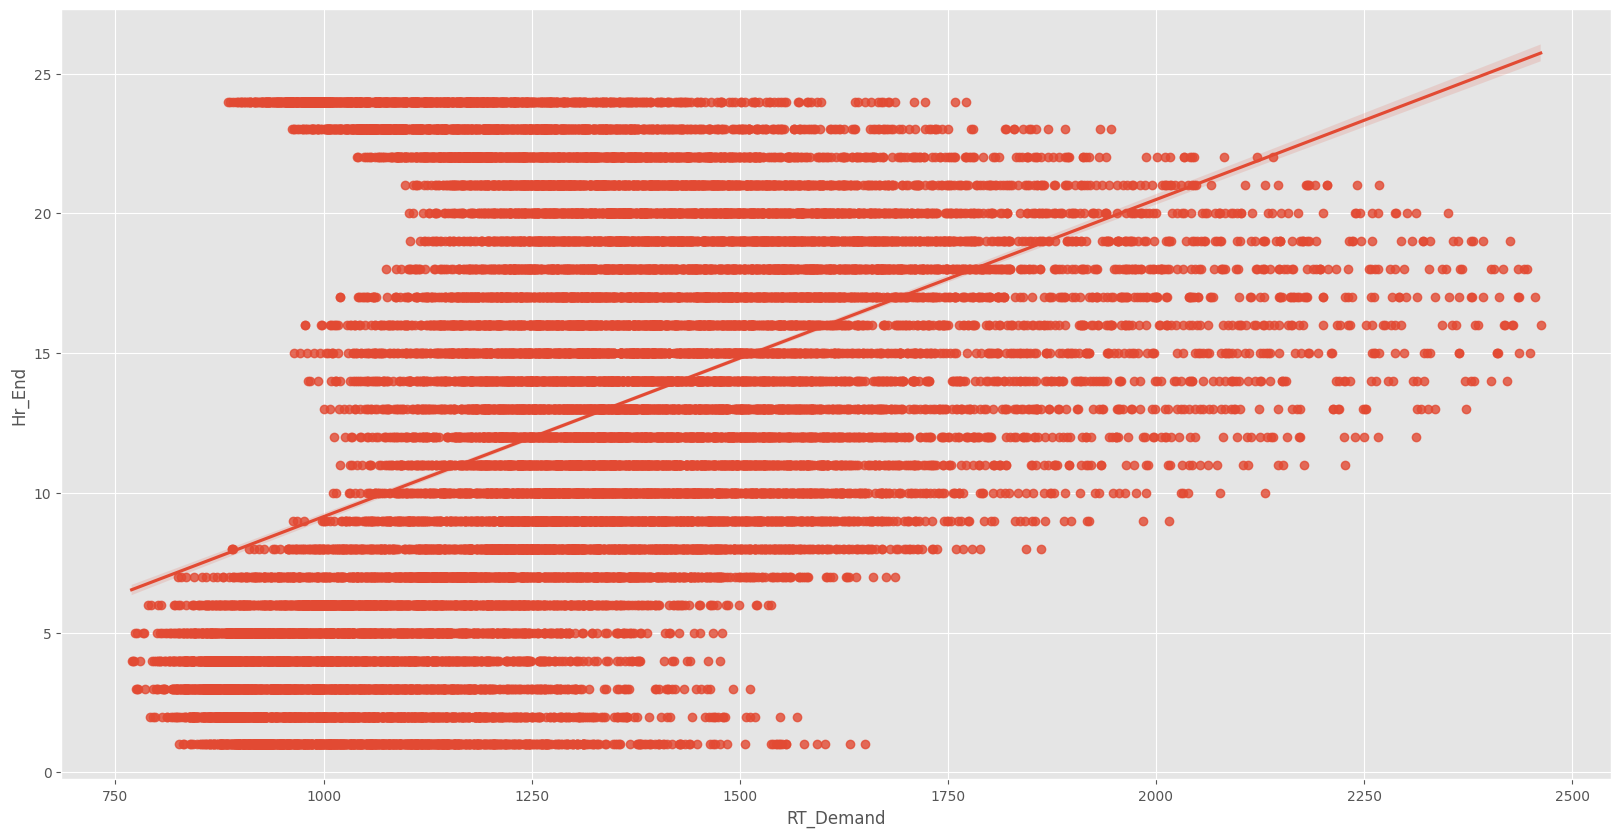

In [ ]:
sns.regplot(x="RT_Demand", y="Hr_End", data= merged_data)
plt.show()

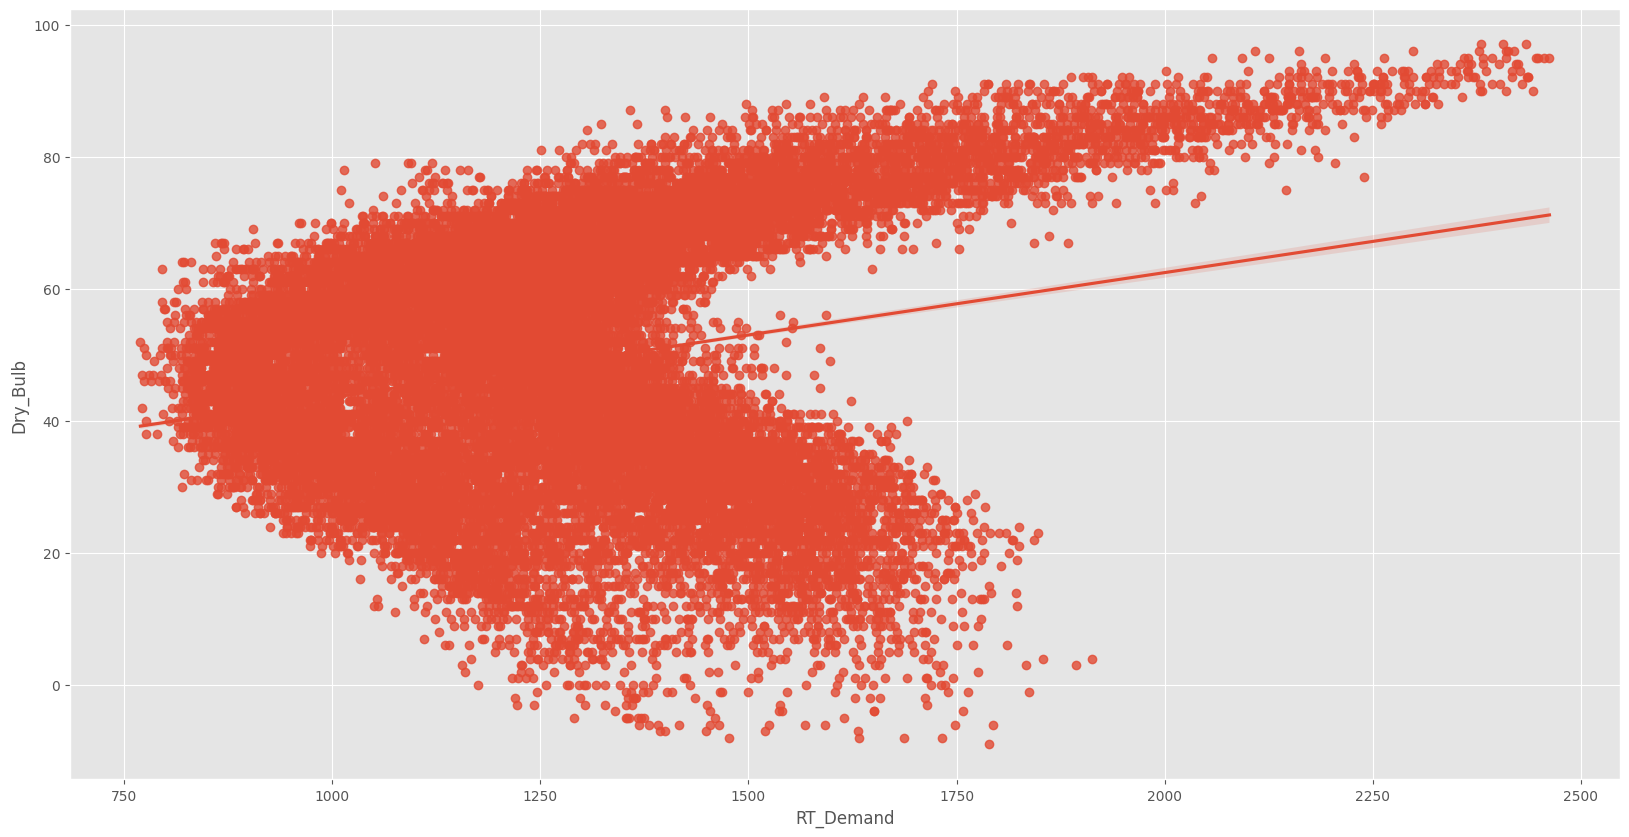

In [ ]:
sns.regplot(x="RT_Demand", y="Dry_Bulb", data= merged_data)
plt.show()

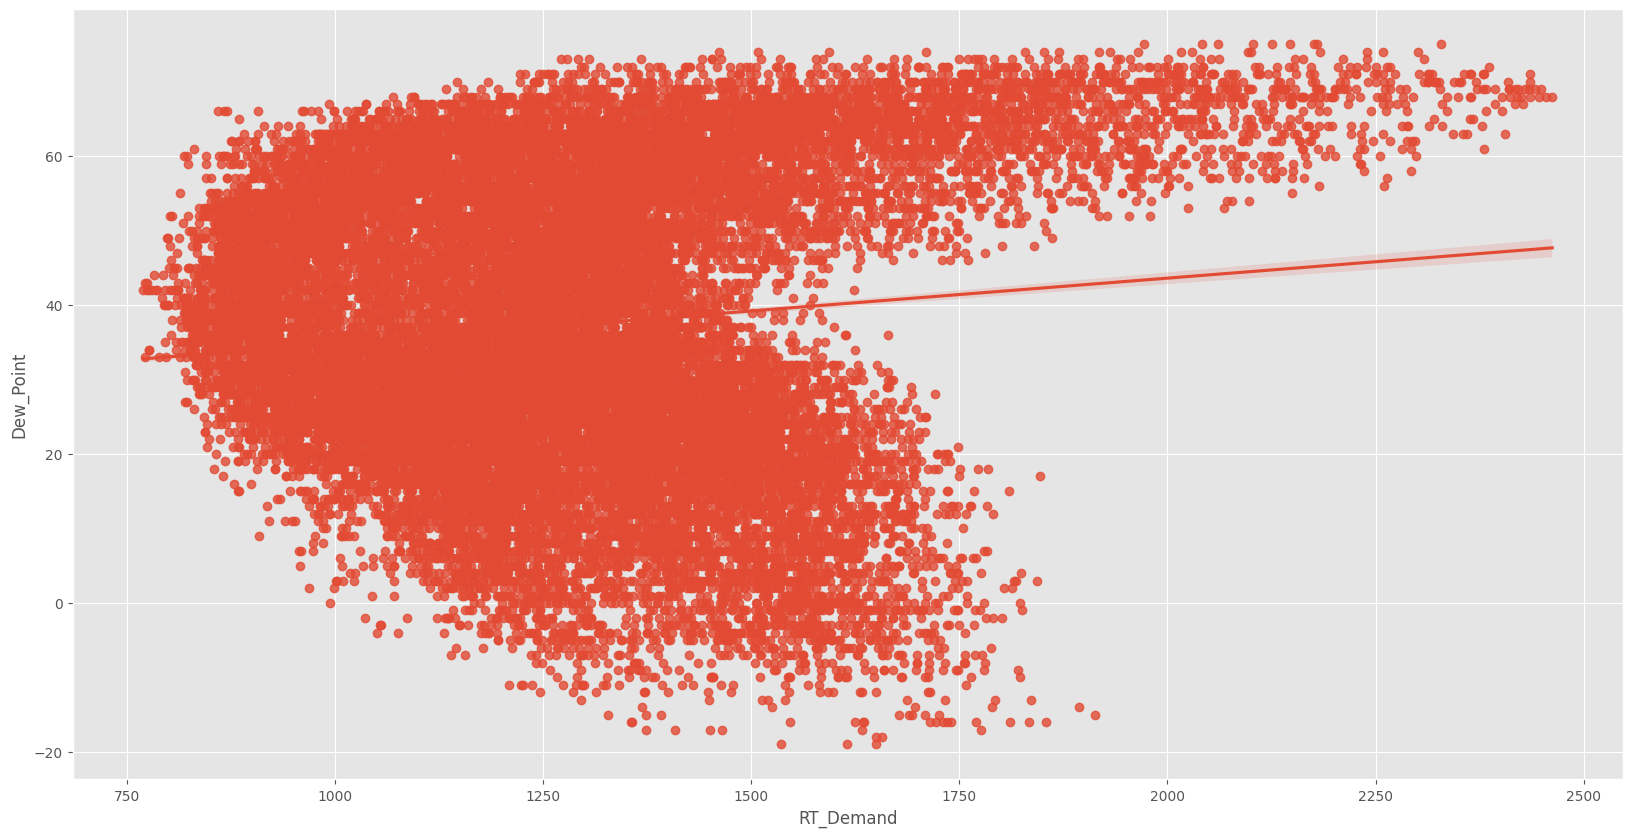

In [ ]:
sns.regplot(x="RT_Demand", y="Dew_Point", data= merged_data)
plt.show()

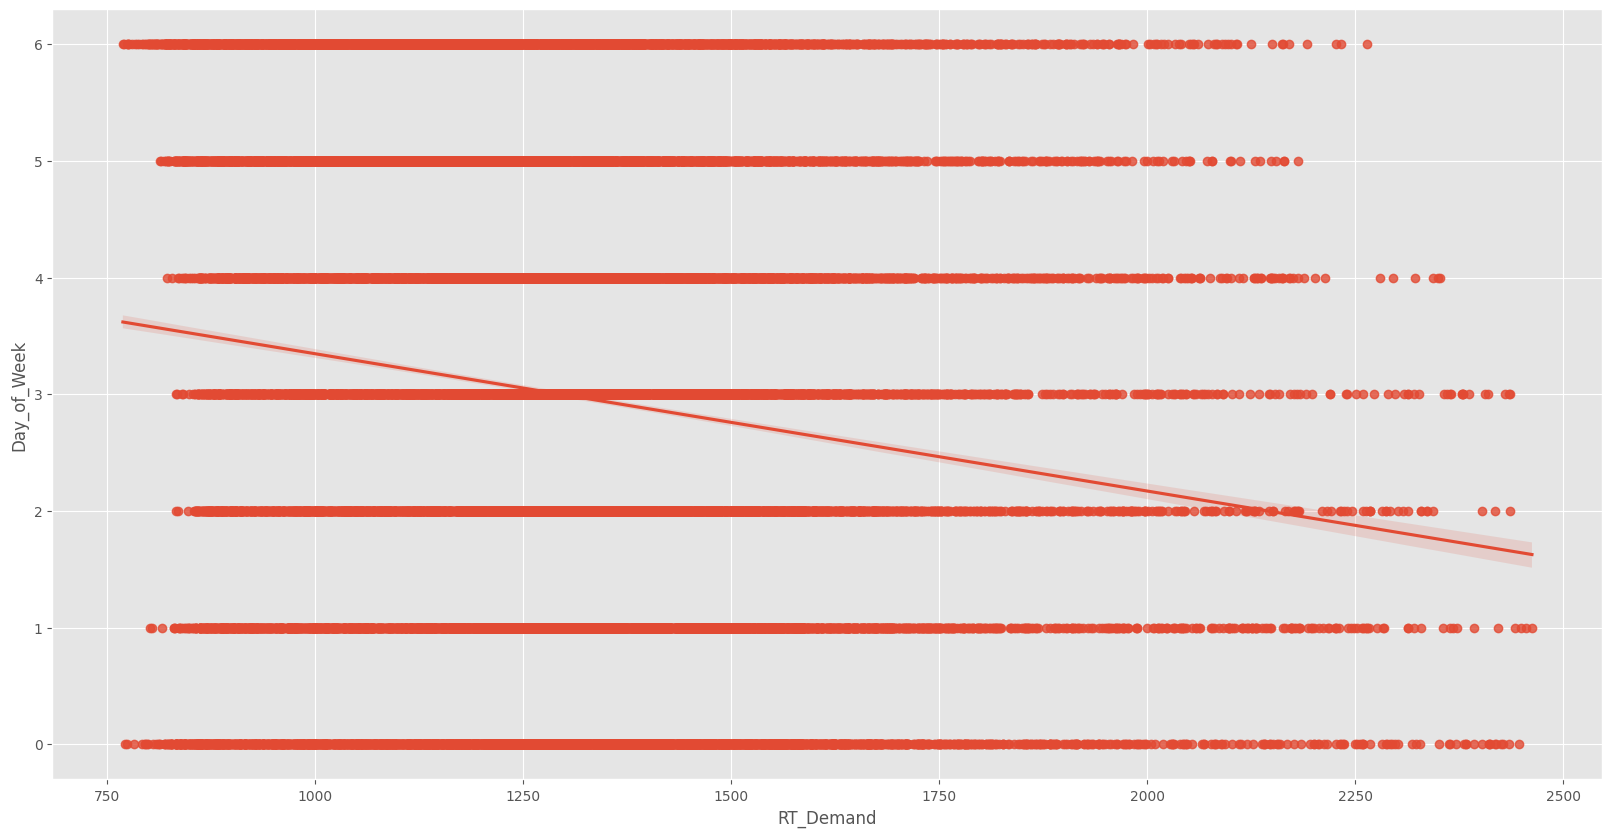

In [ ]:
sns.regplot(x="RT_Demand", y="Day_of_Week", data= merged_data)
plt.show()

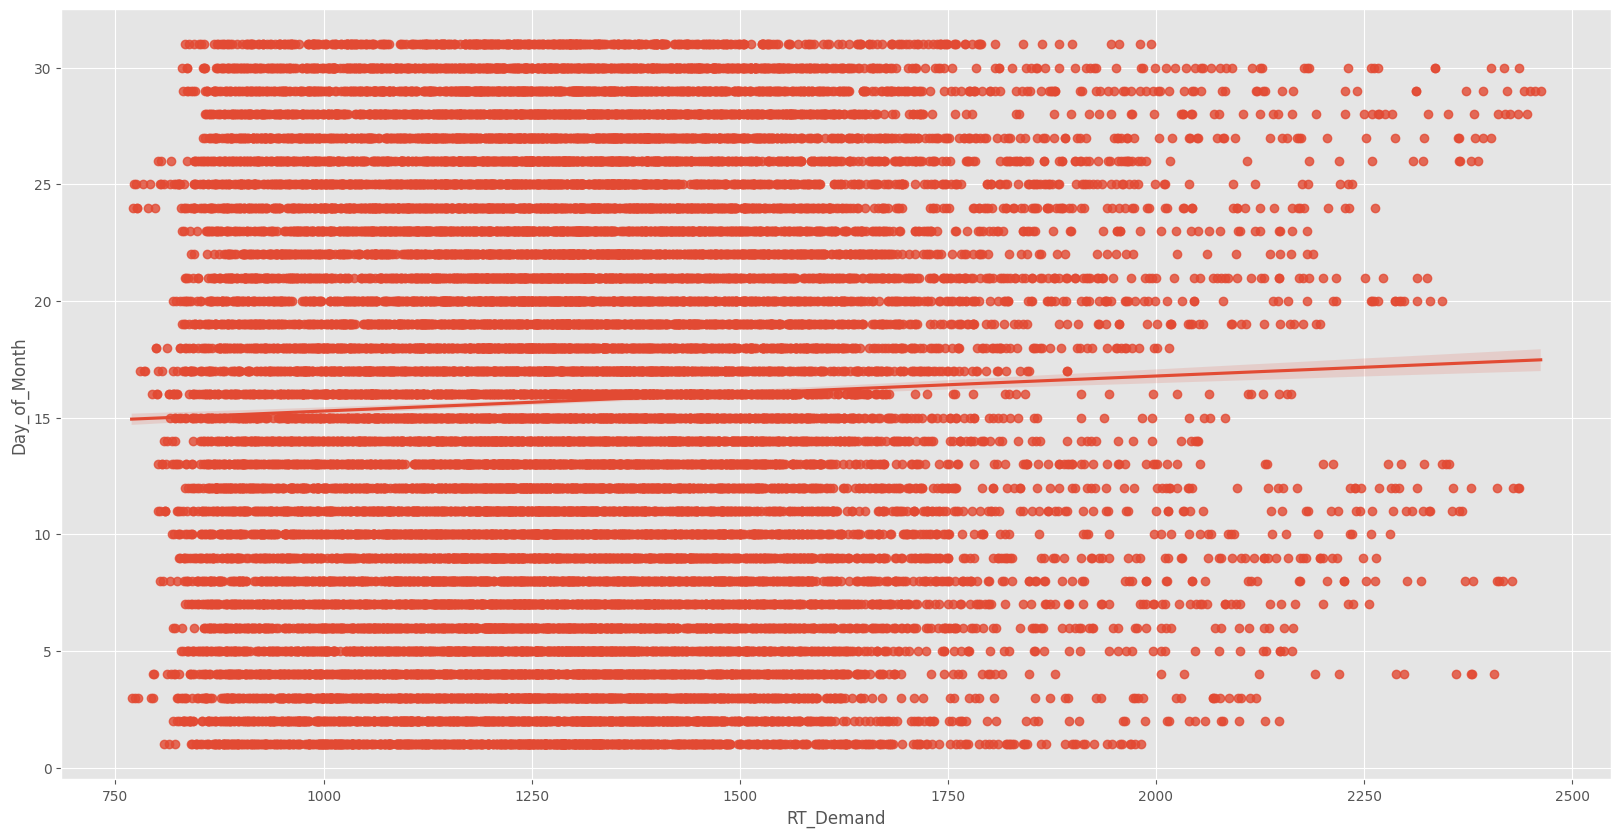

In [ ]:
sns.regplot(x="RT_Demand", y="Day_of_Month", data= merged_data)
plt.show()

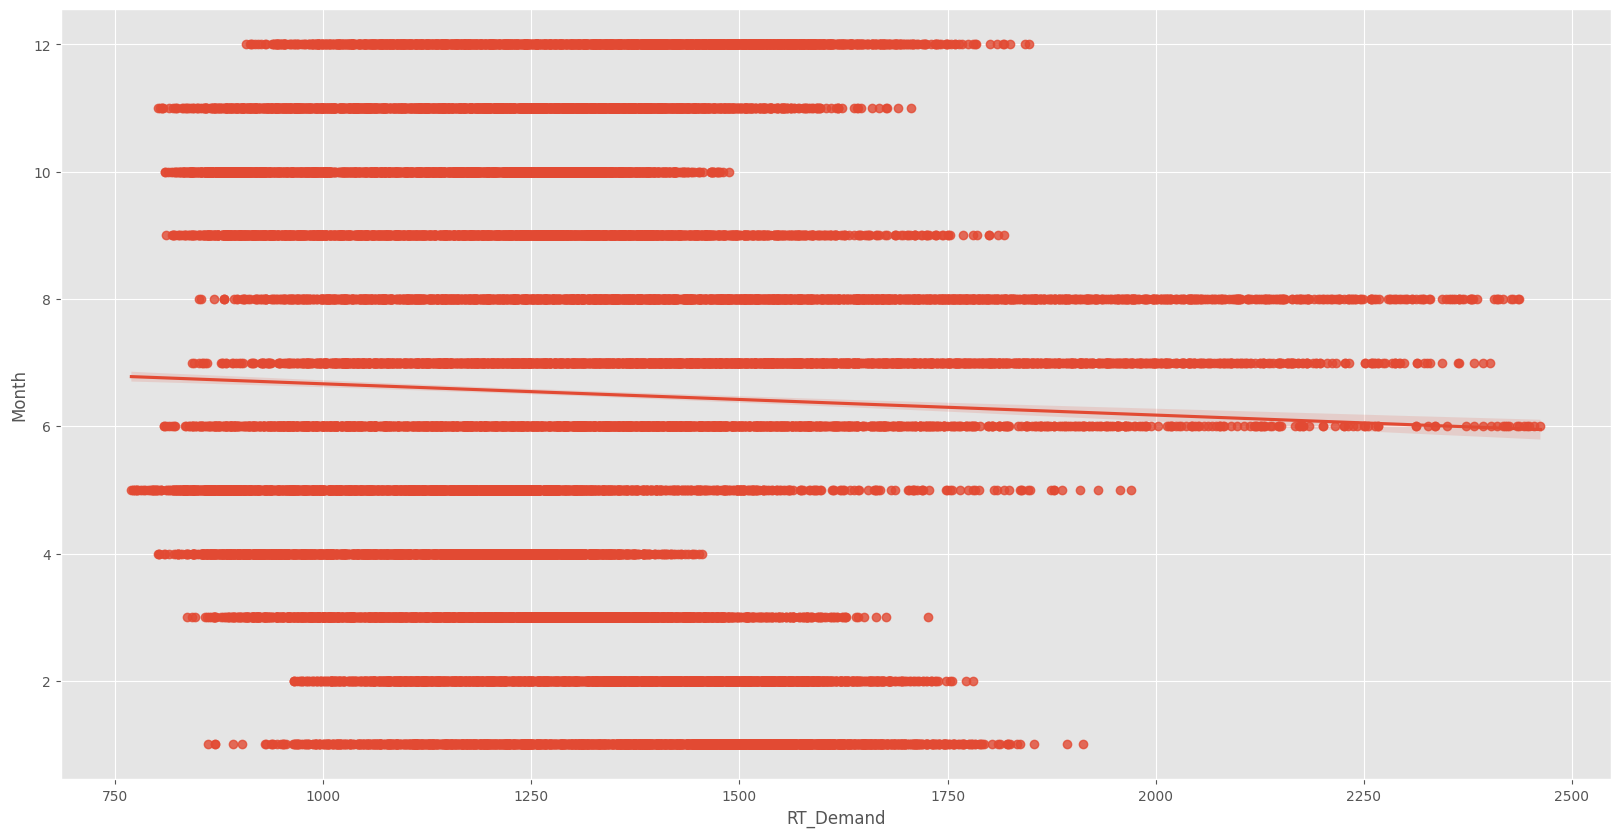

In [ ]:
sns.regplot(x="RT_Demand", y="Month", data= merged_data)
plt.show()

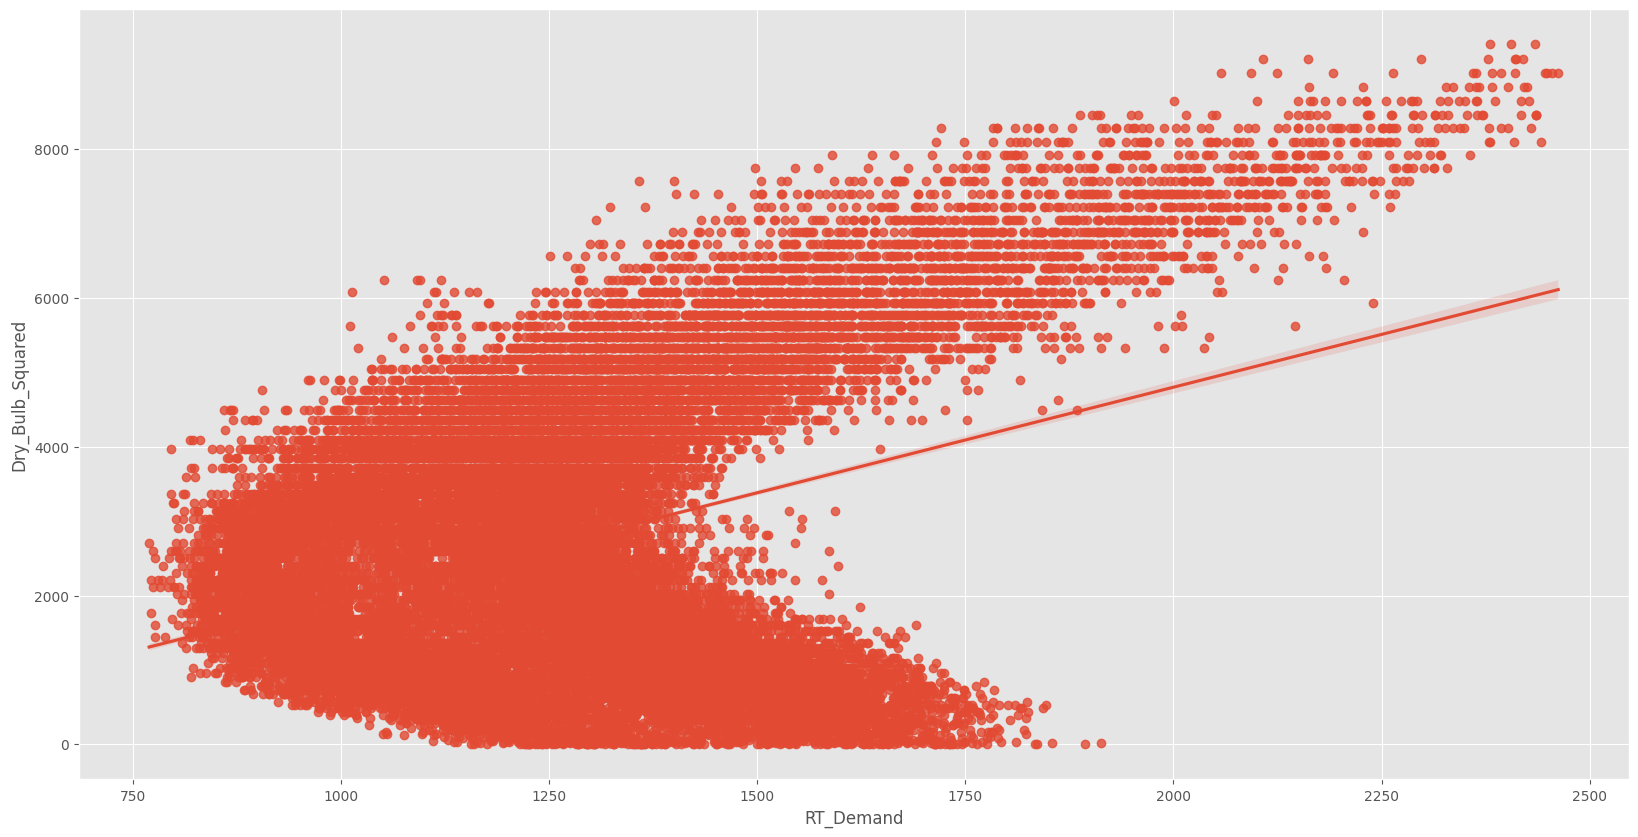

In [ ]:
sns.regplot(x="RT_Demand", y="Dry_Bulb_Squared", data= merged_data)
plt.show()

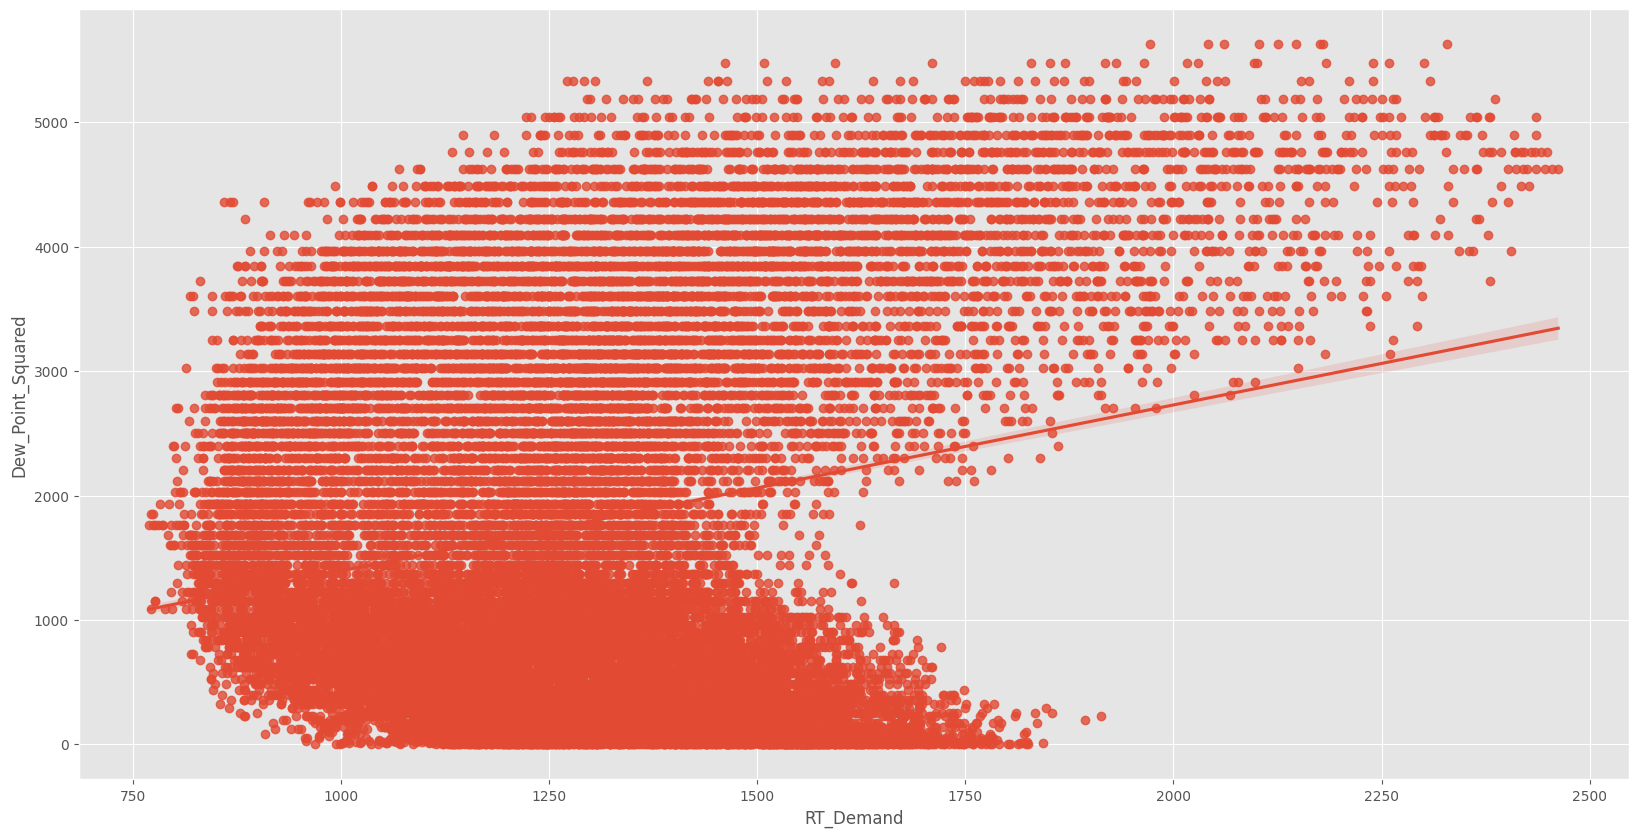

In [ ]:
sns.regplot(x="RT_Demand", y="Dew_Point_Squared", data= merged_data)
plt.show()

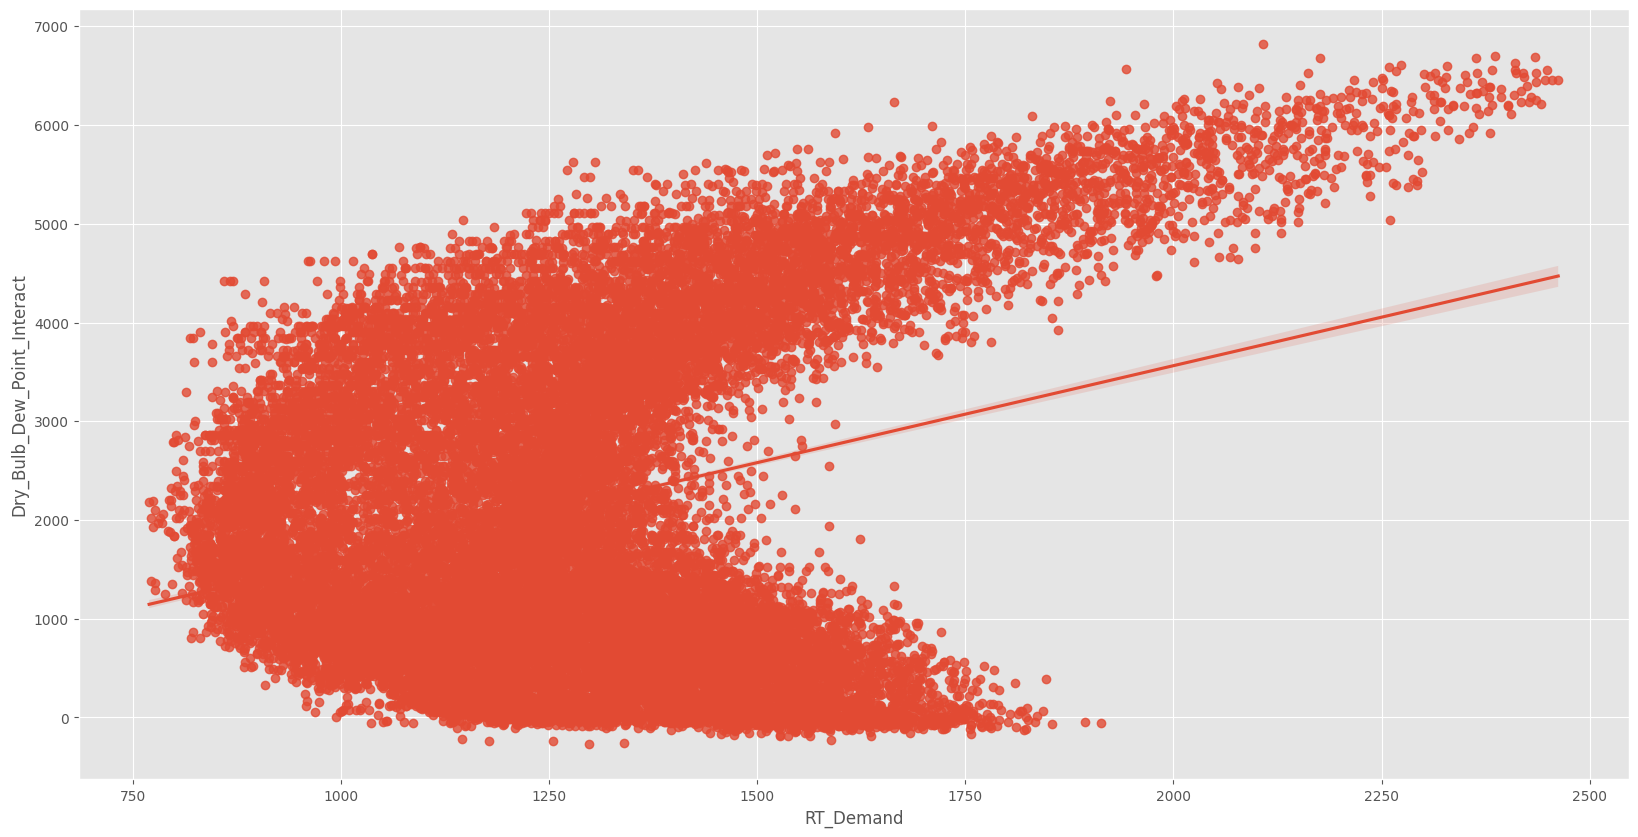

In [ ]:
sns.regplot(x="RT_Demand", y="Dry_Bulb_Dew_Point_Interact", data= merged_data)
plt.show()

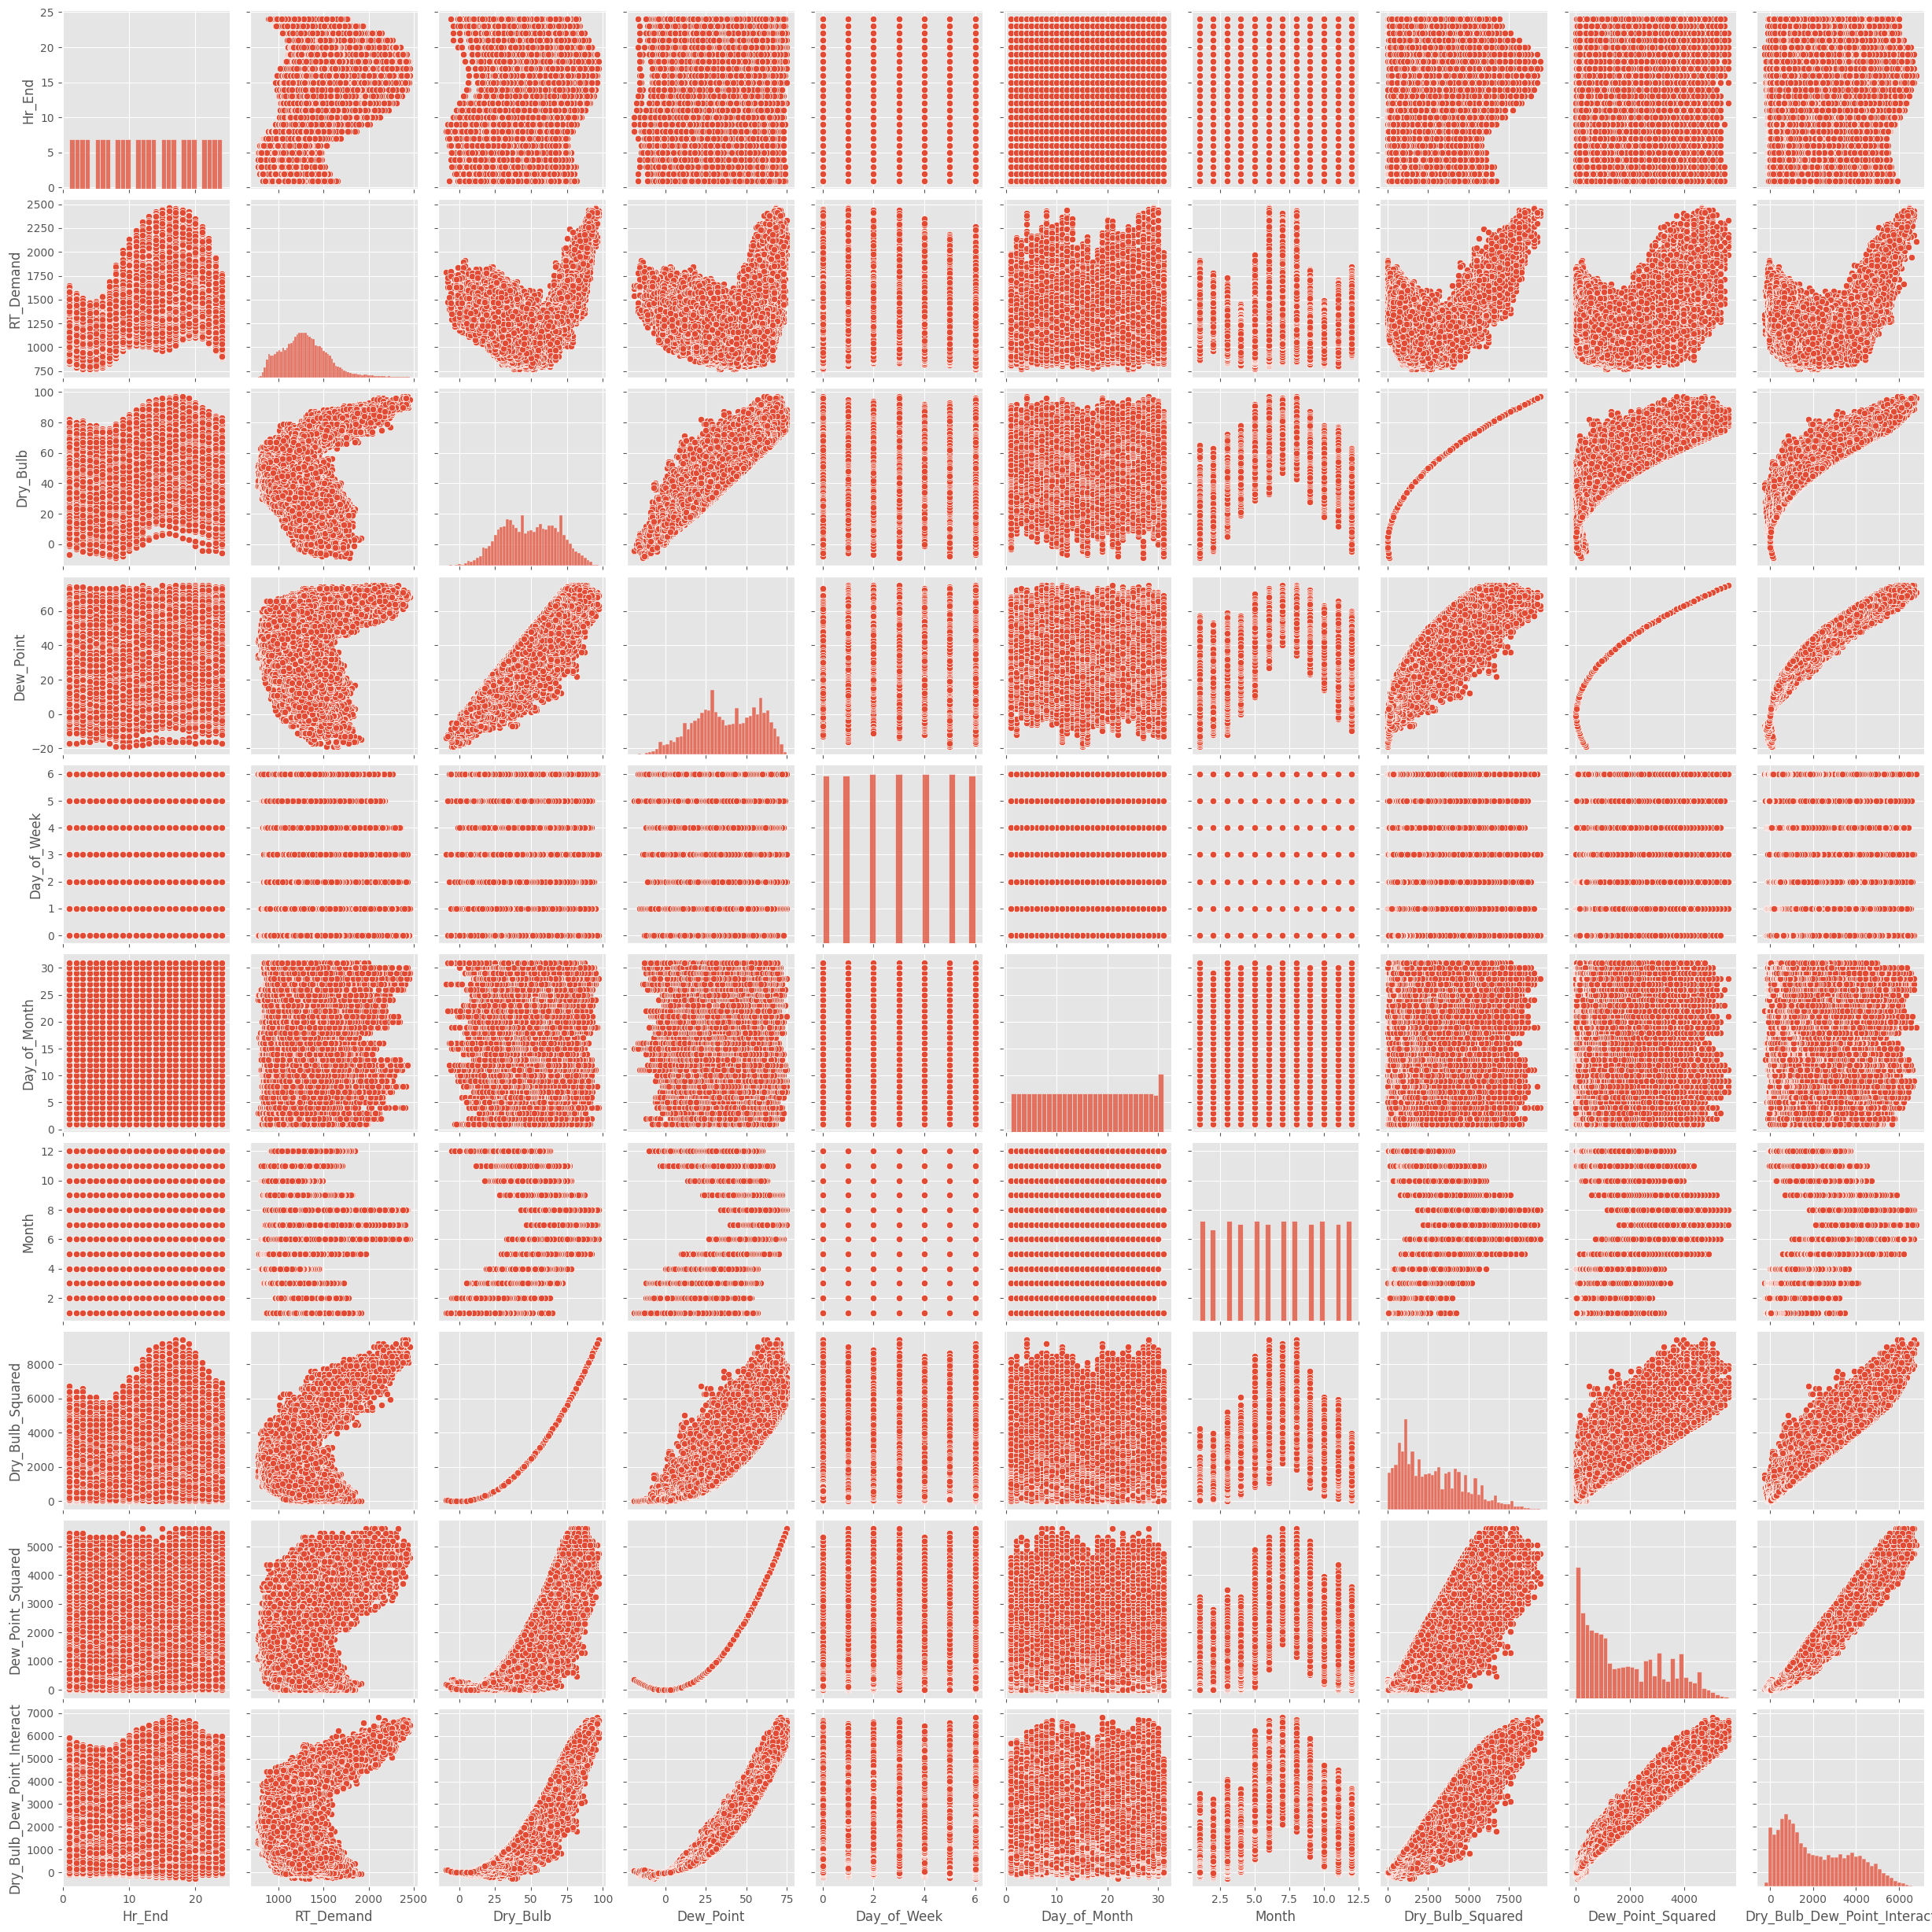

In [ ]:
sns.pairplot(merged_data);

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [ ]:
# Handling missing values
merged_data.fillna(merged_data.mean(), inplace=True)

# Define features and response variable
features = ['Hr_End', 'Dry_Bulb', 'Dew_Point', 'Day_of_Week', 'Day_of_Month', 'Month',
            'Dry_Bulb_Squared', 'Dew_Point_Squared', 'Dry_Bulb_Dew_Point_Interact']
response_variable = 'RT_Demand'

X = merged_data[features]
y = merged_data[response_variable]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Random Forest Regressor
# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
predictions = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

# Prediction for the next 30 days
forecast_start_date = pd.to_datetime('2023-01-01')
forecast_end_date = pd.to_datetime('2023-01-31')
forecast_dates = pd.date_range(forecast_start_date, forecast_end_date, freq='H')

# Create a DataFrame for the next 30 days with the same features
forecast_data = pd.DataFrame(index=forecast_dates, columns=features)
forecast_data['Hr_End'] = forecast_data.index.hour
forecast_data['Day_of_Week'] = forecast_data.index.dayofweek
forecast_data['Day_of_Month'] = forecast_data.index.day
forecast_data['Month'] = forecast_data.index.month
forecast_data['Dry_Bulb_Squared'] = forecast_data['Dry_Bulb'] ** 2
forecast_data['Dew_Point_Squared'] = forecast_data['Dew_Point'] ** 2
forecast_data['Dry_Bulb_Dew_Point_Interact'] = forecast_data['Dry_Bulb'] * forecast_data['Dew_Point']

# Handling missing values in the forecast data
forecast_data.fillna(merged_data.mean(), inplace=True)

# Make predictions for the next 30 days
forecast_values = model.predict(forecast_data)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(index=forecast_dates, columns=['Forecasted_RT_Demand'])
forecast_df['Forecasted_RT_Demand'] = forecast_values

# Print or use the forecast DataFrame as needed
print(forecast_df)


RMSE: 48.87307646048841
R-squared: 0.9665741166177411
                     Forecasted_RT_Demand
2023-01-01 00:00:00             996.47452
2023-01-01 01:00:00             996.47452
2023-01-01 02:00:00             974.96574
2023-01-01 03:00:00             953.55848
2023-01-01 04:00:00             951.76935
...                                   ...
2023-01-30 20:00:00            1412.67428
2023-01-30 21:00:00            1385.09130
2023-01-30 22:00:00            1248.06342
2023-01-30 23:00:00            1131.56684
2023-01-31 00:00:00            1036.63985

[721 rows x 1 columns]


In [ ]:
# Linear Regression
from sklearn.linear_model import LinearRegression
# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Model evaluation
predictions = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

# Prediction for the next 30 days
forecast_start_date = pd.to_datetime('2023-01-01')
forecast_end_date = pd.to_datetime('2023-01-31')
forecast_dates = pd.date_range(forecast_start_date, forecast_end_date, freq='H')

# Create a DataFrame for the next 30 days with the same features
forecast_data = pd.DataFrame(index=forecast_dates, columns=features)
forecast_data['Hr_End'] = forecast_data.index.hour
forecast_data['Day_of_Week'] = forecast_data.index.dayofweek
forecast_data['Day_of_Month'] = forecast_data.index.day
forecast_data['Month'] = forecast_data.index.month
forecast_data['Dry_Bulb_Squared'] = forecast_data['Dry_Bulb'] ** 2
forecast_data['Dew_Point_Squared'] = forecast_data['Dew_Point'] ** 2
forecast_data['Dry_Bulb_Dew_Point_Interact'] = forecast_data['Dry_Bulb'] * forecast_data['Dew_Point']

# Handling missing values in the forecast data
forecast_data.fillna(merged_data.mean(), inplace=True)

# Make predictions for the next 30 days
forecast_values = model.predict(forecast_data)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(index=forecast_dates, columns=['Forecasted_RT_Demand'])
forecast_df['Forecasted_RT_Demand'] = forecast_values

# Print or use the forecast DataFrame as needed
print(forecast_df)

RMSE: 167.71843563051107
R-squared: 0.6063546334969703
                     Forecasted_RT_Demand
2023-01-01 00:00:00           1051.688772
2023-01-01 01:00:00           1065.041882
2023-01-01 02:00:00           1078.394992
2023-01-01 03:00:00           1091.748102
2023-01-01 04:00:00           1105.101213
...                                   ...
2023-01-30 20:00:00           1460.731267
2023-01-30 21:00:00           1474.084378
2023-01-30 22:00:00           1487.437488
2023-01-30 23:00:00           1500.790598
2023-01-31 00:00:00           1171.547565

[721 rows x 1 columns]


In [ ]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
# Model training
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Model evaluation
predictions = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

# Prediction for the next 30 days
forecast_start_date = pd.to_datetime('2023-01-01')
forecast_end_date = pd.to_datetime('2023-01-31')
forecast_dates = pd.date_range(forecast_start_date, forecast_end_date, freq='H')

# Create a DataFrame for the next 30 days with the same features
forecast_data = pd.DataFrame(index=forecast_dates, columns=features)
forecast_data['Hr_End'] = forecast_data.index.hour
forecast_data['Day_of_Week'] = forecast_data.index.dayofweek
forecast_data['Day_of_Month'] = forecast_data.index.day
forecast_data['Month'] = forecast_data.index.month
forecast_data['Dry_Bulb_Squared'] = forecast_data['Dry_Bulb'] ** 2
forecast_data['Dew_Point_Squared'] = forecast_data['Dew_Point'] ** 2
forecast_data['Dry_Bulb_Dew_Point_Interact'] = forecast_data['Dry_Bulb'] * forecast_data['Dew_Point']

# Handling missing values in the forecast data
forecast_data.fillna(merged_data.mean(), inplace=True)

# Make predictions for the next 30 days
forecast_values = model.predict(forecast_data)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(index=forecast_dates, columns=['Forecasted_RT_Demand'])
forecast_df['Forecasted_RT_Demand'] = forecast_values

# Print or use the forecast DataFrame as needed
print(forecast_df)



RMSE: 66.97982720767929
R-squared: 0.9372185150614543
                     Forecasted_RT_Demand
2023-01-01 00:00:00               831.210
2023-01-01 01:00:00               831.210
2023-01-01 02:00:00               915.293
2023-01-01 03:00:00               803.093
2023-01-01 04:00:00               803.093
...                                   ...
2023-01-30 20:00:00              1408.912
2023-01-30 21:00:00              1408.912
2023-01-30 22:00:00              1259.713
2023-01-30 23:00:00              1154.849
2023-01-31 00:00:00              1056.306

[721 rows x 1 columns]


In [ ]:
# Bagging with Random Forest
from sklearn.ensemble import BaggingRegressor
# Model training with BaggingRegressor using RandomForestRegressor as the base estimator
base_estimator = RandomForestRegressor(n_estimators=100, random_state=42)
model = BaggingRegressor(base_estimator=base_estimator, n_estimators=10, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
predictions = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

# Prediction for the next 30 days
forecast_start_date = pd.to_datetime('2023-01-01')
forecast_end_date = pd.to_datetime('2023-01-31')
forecast_dates = pd.date_range(forecast_start_date, forecast_end_date, freq='H')

# Create a DataFrame for the next 30 days with the same features
forecast_data = pd.DataFrame(index=forecast_dates, columns=features)
forecast_data['Hr_End'] = forecast_data.index.hour
forecast_data['Day_of_Week'] = forecast_data.index.dayofweek
forecast_data['Day_of_Month'] = forecast_data.index.day
forecast_data['Month'] = forecast_data.index.month
forecast_data['Dry_Bulb_Squared'] = forecast_data['Dry_Bulb'] ** 2
forecast_data['Dew_Point_Squared'] = forecast_data['Dew_Point'] ** 2
forecast_data['Dry_Bulb_Dew_Point_Interact'] = forecast_data['Dry_Bulb'] * forecast_data['Dew_Point']

# Handling missing values in the forecast data
forecast_data.fillna(merged_data.mean(), inplace=True)

# Make predictions for the next 30 days
forecast_values = model.predict(forecast_data)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(index=forecast_dates, columns=['Forecasted_RT_Demand'])
forecast_df['Forecasted_RT_Demand'] = forecast_values

# Print or use the forecast DataFrame as needed
print(forecast_df)


RMSE: 51.134698871255814
R-squared: 0.9634089439740949
                     Forecasted_RT_Demand
2023-01-01 00:00:00            986.422591
2023-01-01 01:00:00            986.422591
2023-01-01 02:00:00            965.872388
2023-01-01 03:00:00            955.940905
2023-01-01 04:00:00            954.334636
...                                   ...
2023-01-30 20:00:00           1408.172793
2023-01-30 21:00:00           1384.121728
2023-01-30 22:00:00           1270.565880
2023-01-30 23:00:00           1122.219795
2023-01-31 00:00:00           1015.896901

[721 rows x 1 columns]


In [ ]:
# Bagging with Decision Tree Regressor
from sklearn.ensemble import BaggingRegressor
# Model training with BaggingRegressor using DecisionTreeRegressor as the base estimator
base_estimator = DecisionTreeRegressor(random_state=42)
model = BaggingRegressor(base_estimator=base_estimator, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
predictions = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

# Prediction for the next 30 days
forecast_start_date = pd.to_datetime('2023-01-01')
forecast_end_date = pd.to_datetime('2023-01-31')
forecast_dates = pd.date_range(forecast_start_date, forecast_end_date, freq='H')

# Create a DataFrame for the next 30 days with the same features
forecast_data = pd.DataFrame(index=forecast_dates, columns=features)
forecast_data['Hr_End'] = forecast_data.index.hour
forecast_data['Day_of_Week'] = forecast_data.index.dayofweek
forecast_data['Day_of_Month'] = forecast_data.index.day
forecast_data['Month'] = forecast_data.index.month
forecast_data['Dry_Bulb_Squared'] = forecast_data['Dry_Bulb'] ** 2
forecast_data['Dew_Point_Squared'] = forecast_data['Dew_Point'] ** 2
forecast_data['Dry_Bulb_Dew_Point_Interact'] = forecast_data['Dry_Bulb'] * forecast_data['Dew_Point']

# Handling missing values in the forecast data
forecast_data.fillna(merged_data.mean(), inplace=True)

# Make predictions for the next 30 days
forecast_values = model.predict(forecast_data)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(index=forecast_dates, columns=['Forecasted_RT_Demand'])
forecast_df['Forecasted_RT_Demand'] = forecast_values

# Print or use the forecast DataFrame as needed
print(forecast_df)

RMSE: 48.96755330568476
R-squared: 0.9664447601463928
                     Forecasted_RT_Demand
2023-01-01 00:00:00             998.06968
2023-01-01 01:00:00             998.06968
2023-01-01 02:00:00             978.36566
2023-01-01 03:00:00             955.85834
2023-01-01 04:00:00             954.09406
...                                   ...
2023-01-30 20:00:00            1414.13473
2023-01-30 21:00:00            1383.79721
2023-01-30 22:00:00            1248.93852
2023-01-30 23:00:00            1127.89543
2023-01-31 00:00:00            1035.85368

[721 rows x 1 columns]
